# Описание.

Есть датасет о совершенных поездках в такси в Нью-Йорке. Предлагается на основе этих данных решить следующие задачи:

1. Оценить корреляцию стоимости поездки с другими факторами.

2. Найти аномальные поездки и объяснить почему именно эти поездки аномальные.

3. Построить распределение по стоимости поездок. Проверить гипотезу о том, что оно имеет нормальное распределение. Объяснить полученные результаты.

4. Из данных постройте модель, которая описывает тариф (т.е. стоимость поездки от других факторов).

5. Используя модель из пункта выше ответьте на вопрос: были ли в какие-то дни (или временные промежутки) скидки или акции? И если  были, то как это можно объяснить.

Датасет и его описание доступны по ссылке: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Сделаем необходимые импорты

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных и первая аналитика.

Загрузим датасет. Я буду пользоваться датасетом за январь 2020 года "green_tripdata_2020-01" (https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2020-01.csv)

In [3]:
data = pd.read_csv('D://Downloads/green_tripdata_2020-01.csv', parse_dates=['lpep_pickup_datetime', 'lpep_dropoff_datetime'])

Я уже посмотрел датасет заранее и сразу при загрузке данных конвертирую некоторые колонки в формат datetime для удобной работы с помощью "date_parser"

In [4]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2019-12-18 15:52:30,2019-12-18 15:54:39,N,1.0,264,264,5.0,0.00,3.5,0.50,0.5,0.01,0.0,NaN,0.3,4.81,1.0,1.0,0.00
1,2.0,2020-01-01 00:45:58,2020-01-01 00:56:39,N,5.0,66,65,2.0,1.28,20.0,0.00,0.0,4.06,0.0,NaN,0.3,24.36,1.0,2.0,0.00
2,2.0,2020-01-01 00:41:38,2020-01-01 00:52:49,N,1.0,181,228,1.0,2.47,10.5,0.50,0.5,3.54,0.0,NaN,0.3,15.34,1.0,1.0,0.00
3,1.0,2020-01-01 00:52:46,2020-01-01 01:14:21,N,1.0,129,263,2.0,6.30,21.0,3.25,0.5,0.00,0.0,NaN,0.3,25.05,2.0,1.0,2.75
4,1.0,2020-01-01 00:19:57,2020-01-01 00:30:56,N,1.0,210,150,1.0,2.30,10.0,0.50,0.5,0.00,0.0,NaN,0.3,11.30,1.0,1.0,0.00


Подробное описание каждого столбца находится по ссылке: https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447770 entries, 0 to 447769
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               331719 non-null  float64       
 1   lpep_pickup_datetime   447770 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  447770 non-null  datetime64[ns]
 3   store_and_fwd_flag     331719 non-null  object        
 4   RatecodeID             331719 non-null  float64       
 5   PULocationID           447770 non-null  int64         
 6   DOLocationID           447770 non-null  int64         
 7   passenger_count        331719 non-null  float64       
 8   trip_distance          447770 non-null  float64       
 9   fare_amount            447770 non-null  float64       
 10  extra                  447770 non-null  float64       
 11  mta_tax                447770 non-null  float64       
 12  tip_amount             447770 non-null  floa

Из info видно, что имеется только 1 столбец object, все остальные признаки численные (int, float, datetime)

In [6]:
# Постмотрим на пропущенные значения
data.isnull().sum()

VendorID                 116051
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag       116051
RatecodeID               116051
PULocationID                  0
DOLocationID                  0
passenger_count          116051
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                447770
improvement_surcharge         0
total_amount                  0
payment_type             116051
trip_type                116052
congestion_surcharge     116051
dtype: int64

Колонка "ehail_fee" полностью пустая, удаляем ее. Остальные пропущенные значения обработаем позже

In [7]:
data.drop("ehail_fee", inplace=True, axis=1)

In [8]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2019-12-18 15:52:30,2019-12-18 15:54:39,N,1.0,264,264,5.0,0.00,3.5,0.50,0.5,0.01,0.0,0.3,4.81,1.0,1.0,0.00
1,2.0,2020-01-01 00:45:58,2020-01-01 00:56:39,N,5.0,66,65,2.0,1.28,20.0,0.00,0.0,4.06,0.0,0.3,24.36,1.0,2.0,0.00
2,2.0,2020-01-01 00:41:38,2020-01-01 00:52:49,N,1.0,181,228,1.0,2.47,10.5,0.50,0.5,3.54,0.0,0.3,15.34,1.0,1.0,0.00
3,1.0,2020-01-01 00:52:46,2020-01-01 01:14:21,N,1.0,129,263,2.0,6.30,21.0,3.25,0.5,0.00,0.0,0.3,25.05,2.0,1.0,2.75
4,1.0,2020-01-01 00:19:57,2020-01-01 00:30:56,N,1.0,210,150,1.0,2.30,10.0,0.50,0.5,0.00,0.0,0.3,11.30,1.0,1.0,0.00


Хотя все данные представлены численным типом (int, float) некоторые переменные являются категориальными (имеют небольшое/ограниченное число значений). Давайте проверим что это за колонки и создадим 2 списка: с категориальными и количественными признаками (cat_cols, num_cols соответственно).

In [9]:
cat_cols = list()
num_cols = list()
for col in data.columns:
    print(f'Колонка "{col}" имеет значений: {data[col].nunique()}')
    if data[col].nunique() < 8:
        cat_cols += [col]
    else:
        num_cols += [col]

Колонка "VendorID" имеет значений: 2
Колонка "lpep_pickup_datetime" имеет значений: 331157
Колонка "lpep_dropoff_datetime" имеет значений: 331043
Колонка "store_and_fwd_flag" имеет значений: 2
Колонка "RatecodeID" имеет значений: 7
Колонка "PULocationID" имеет значений: 251
Колонка "DOLocationID" имеет значений: 257
Колонка "passenger_count" имеет значений: 10
Колонка "trip_distance" имеет значений: 3555
Колонка "fare_amount" имеет значений: 6037
Колонка "extra" имеет значений: 13
Колонка "mta_tax" имеет значений: 4
Колонка "tip_amount" имеет значений: 1468
Колонка "tolls_amount" имеет значений: 94
Колонка "improvement_surcharge" имеет значений: 3
Колонка "total_amount" имеет значений: 7072
Колонка "payment_type" имеет значений: 5
Колонка "trip_type" имеет значений: 2
Колонка "congestion_surcharge" имеет значений: 5


Пороговое значение - 8 уникальных значений в столбце. Колонку "passenger_count" (количество пассажиров) пока отнесем к количественным столбцам

In [10]:
# Посмотрим на основные статистики числовых столбцов

data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
PULocationID,447770.0,108.121236,71.165956,1.00,52.00,82.00,166.00,265.00
DOLocationID,447770.0,128.864473,76.446125,1.00,63.00,129.00,194.00,265.00
passenger_count,331719.0,1.304110,0.953394,0.00,1.00,1.00,1.00,9.00
trip_distance,447770.0,3.599392,4.257709,-33.69,1.08,2.07,4.41,130.68
fare_amount,447770.0,15.839504,12.691982,-210.00,7.00,11.50,21.00,753.00
extra,447770.0,0.838858,1.149168,-4.50,0.00,0.50,1.00,8.25
tip_amount,447770.0,0.899788,2.319882,-2.80,0.00,0.00,1.46,450.00
tolls_amount,447770.0,0.327172,1.458425,-6.12,0.00,0.00,0.00,96.12
total_amount,447770.0,18.898600,14.101771,-210.30,9.12,14.40,24.55,753.80


Сразу бросаются в глаза отрицательные значения min-статистики в колонках "расстояния" и "оплаты" (trip_distance, fare_amount, extra, tip_amount, tolls_amount, total_amount), кол-во пассажиров = 0 и некоторые max значения. Но это подробнее рассмотрим в главе аномалии.

# 1. Рассмотрим корелляцию стоимости поездки с остальными факторами

In [12]:
data[num_cols].corr()

,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount,total_amount
PULocationID,1.000000,0.143260,0.019897,0.093852,0.112294,0.067897,-0.012021,0.058152,0.105599
DOLocationID,0.143260,1.000000,0.010806,0.062058,0.059307,0.012021,0.077406,0.025770,0.085492
passenger_count,0.019897,0.010806,1.000000,0.009466,-0.006714,-0.008160,0.006240,-0.004514,-0.003582
trip_distance,0.093852,0.062058,0.009466,1.000000,0.835261,0.276670,0.056151,0.514307,0.834405
fare_amount,0.112294,0.059307,-0.006714,0.835261,1.000000,0.388232,0.032393,0.439225,0.977012
extra,0.067897,0.012021,-0.008160,0.276670,0.388232,1.000000,-0.110472,0.133736,0.408653
tip_amount,-0.012021,0.077406,0.006240,0.056151,0.032393,-0.110472,1.000000,0.015350,0.206219
tolls_amount,0.058152,0.025770,-0.004514,0.514307,0.439225,0.133736,0.015350,1.000000,0.506958
total_amount,0.105599,0.085492,-0.003582,0.834405,0.977012,0.408653,0.206219,0.506958,1.000000


Общая сумма поездки "total_amount". Смотрим именно на эту строчку 

### Выводы:
- Из таблицы видно что самая сильная корреляция общей суммы с trip_distance (длинной поездки) и fare_amount (цена время-дистанции поездки рассчитанная за метр). 
- Достаточно логичный вывод: чем дальше едем, тем дороже поездка. 
- И соответственно чем выше стоимость "за метр", тем дороже выйдет вся поездка. 
- Также есть корреляция (0.5) с переменной tolls_amount(общие сборы во время поездки). Тоже достаточно логично: больше сборы = дороже поездка

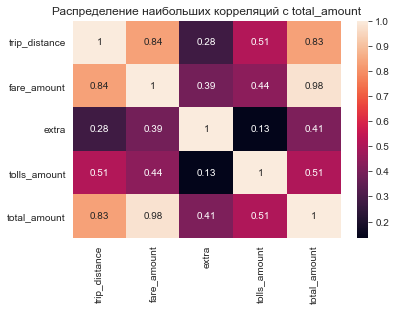

In [13]:
# Построим для наглядности heatmap

cols_for_heatmap = ['trip_distance', 'fare_amount', 'extra', 'tolls_amount', 'total_amount']

sns.heatmap(data[cols_for_heatmap].corr(), annot=True)
plt.title('Распределение наибольших корреляций с total_amount')
plt.show()

Здесь мы можем наблюдать как переменные скоррелированные с total_amount влияют друг на друга. У некоторых присутствует сильная корреляция

# 2. Аномальные поездки

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,331719.0,1.830317,0.375354,1.00,2.00,2.00,2.00,2.00
RatecodeID,331719.0,1.101661,0.664471,1.00,1.00,1.00,1.00,99.00
PULocationID,447770.0,108.121236,71.165956,1.00,52.00,82.00,166.00,265.00
DOLocationID,447770.0,128.864473,76.446125,1.00,63.00,129.00,194.00,265.00
passenger_count,331719.0,1.304110,0.953394,0.00,1.00,1.00,1.00,9.00
trip_distance,447770.0,3.599392,4.257709,-33.69,1.08,2.07,4.41,130.68
fare_amount,447770.0,15.839504,12.691982,-210.00,7.00,11.50,21.00,753.00
extra,447770.0,0.838858,1.149168,-4.50,0.00,0.50,1.00,8.25
mta_tax,447770.0,0.388785,0.210808,-0.50,0.50,0.50,0.50,3.55
tip_amount,447770.0,0.899788,2.319882,-2.80,0.00,0.00,1.46,450.00


Оставим только колонки с числами

In [15]:
numeric_data = data.drop(cat_cols, axis=1)

In [16]:
numeric_data

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount,total_amount
0,2019-12-18 15:52:30,2019-12-18 15:54:39,264,264,5.0,0.00,3.50,0.50,0.01,0.0,4.81
1,2020-01-01 00:45:58,2020-01-01 00:56:39,66,65,2.0,1.28,20.00,0.00,4.06,0.0,24.36
2,2020-01-01 00:41:38,2020-01-01 00:52:49,181,228,1.0,2.47,10.50,0.50,3.54,0.0,15.34
3,2020-01-01 00:52:46,2020-01-01 01:14:21,129,263,2.0,6.30,21.00,3.25,0.00,0.0,25.05
4,2020-01-01 00:19:57,2020-01-01 00:30:56,210,150,1.0,2.30,10.00,0.50,0.00,0.0,11.30
...,...,...,...,...,...,...,...,...,...,...,...
447765,2020-01-31 23:29:00,2020-01-31 23:47:00,167,32,NaN,4.58,23.21,2.75,0.00,0.0,26.26
447766,2020-01-31 23:57:00,2020-02-01 00:23:00,81,69,NaN,6.55,27.27,2.75,0.00,0.0,30.32
447767,2020-01-31 23:57:00,2020-02-01 00:10:00,244,241,NaN,3.34,25.95,2.75,0.00,0.0,29.00
447768,2020-01-31 23:27:00,2020-02-01 00:04:00,68,17,NaN,8.92,30.39,2.75,0.00,0.0,33.44


In [17]:
# Выделим отдельно колонки с датой и временем

time_cols = data.select_dtypes(include='datetime').columns
time_cols

Index(['lpep_pickup_datetime', 'lpep_dropoff_datetime'], dtype='object')

In [18]:
numeric_data.dtypes

lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
tip_amount                      float64
tolls_amount                    float64
total_amount                    float64
dtype: object

In [19]:
numeric_data.isnull().sum()

lpep_pickup_datetime          0
lpep_dropoff_datetime         0
PULocationID                  0
DOLocationID                  0
passenger_count          116051
trip_distance                 0
fare_amount                   0
extra                         0
tip_amount                    0
tolls_amount                  0
total_amount                  0
dtype: int64

Много пропущенных значений в passenger_count (количество пассажиров). Посмотрим на них подробнее

In [20]:
numeric_data.passenger_count.describe()

count    331719.000000
mean          1.304110
std           0.953394
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: passenger_count, dtype: float64

In [21]:
numeric_data.passenger_count.value_counts()

1.0    285729
2.0     24697
5.0      9584
3.0      4900
6.0      4782
4.0      1498
0.0       507
8.0        13
7.0         7
9.0         2
Name: passenger_count, dtype: int64

Сделаю пару замечаний:
- есть большие значения количества пассажиров: 7, 8, 9 - это может быть минивен или еще что-то, так что думаю это допустимые значения;
- присутствуют нулевые значение пассажиров - возможно заказ был отменен, возможно ошибка заполнения данных
- подавляющее большинство поездок совершено 1 пассажиром

In [22]:
print(f'{round(285729 / 447770 * 100, 2)}% поездок совершено 1 пассажиром')
print(f'{round(24697 / 447770 * 100, 2)}% поездок совершено 2 пассажирами')
print(f'{round(116051 / 447770 * 100, 2)}% пропущенных значений')

63.81% поездок совершено 1 пассажиром
5.52% поездок совершено 2 пассажирами
25.92% пропущенных значений


Достаточно большое количество пропущенных значений. Но выкидывать эту колонку не будем, заполним пропуски медианным значением (в нашем случае оно совпадает со средним и модой), т.е. 1

In [23]:
numeric_data.passenger_count.fillna(numeric_data.passenger_count.median(), inplace=True)

In [24]:
numeric_data.isnull().sum()

lpep_pickup_datetime     0
lpep_dropoff_datetime    0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
tip_amount               0
tolls_amount             0
total_amount             0
dtype: int64

### Дальше рассмотрим нашу целевую переменную (total_amount)

In [25]:
numeric_data.total_amount.describe()

count    447770.000000
mean         18.898600
std          14.101771
min        -210.300000
25%           9.120000
50%          14.400000
75%          24.550000
max         753.800000
Name: total_amount, dtype: float64

Странное минимальное значение -210.3. Думаю это и есть наши аномалии. Проверим сколько отрицательных чеков

In [26]:
free_trip = data[numeric_data['total_amount'] < 0]
free_trip

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
275,2.0,2020-01-01 00:55:51,2020-01-01 01:01:58,N,1.0,80,256,2.0,0.71,-5.50,-0.50,-0.5,0.0,0.0,-0.3,-6.80,3.0,1.0,0.0
1772,2.0,2020-01-01 02:15:31,2020-01-01 02:20:12,N,1.0,256,256,2.0,0.63,-5.00,-0.50,-0.5,0.0,0.0,-0.3,-6.30,3.0,1.0,0.0
1910,2.0,2020-01-01 02:30:01,2020-01-01 02:32:54,N,1.0,42,42,1.0,0.57,-4.00,-0.50,-0.5,0.0,0.0,-0.3,-5.30,4.0,1.0,0.0
2024,2.0,2020-01-01 02:37:22,2020-01-01 02:38:26,N,1.0,256,256,1.0,0.15,-3.00,-0.50,-0.5,0.0,0.0,-0.3,-4.30,3.0,1.0,0.0
2538,2.0,2020-01-01 03:54:41,2020-01-01 03:58:31,N,1.0,61,177,1.0,0.81,-5.00,-0.50,-0.5,0.0,0.0,-0.3,-6.30,4.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443141,NaN,2020-01-30 12:13:00,2020-01-30 12:16:00,NaN,NaN,95,95,NaN,0.38,-18.49,2.75,0.0,0.0,0.0,0.3,-15.44,NaN,NaN,NaN
443594,NaN,2020-01-30 15:15:00,2020-01-30 15:33:00,NaN,NaN,72,91,NaN,2.96,-32.57,2.75,0.5,0.0,0.0,0.0,-29.32,NaN,NaN,NaN
443605,NaN,2020-01-30 15:15:00,2020-01-30 15:25:00,NaN,NaN,7,7,NaN,0.31,-22.93,2.75,0.0,0.0,0.0,0.3,-19.88,NaN,NaN,NaN
444281,NaN,2020-01-30 18:23:00,2020-01-30 18:29:00,NaN,NaN,42,42,NaN,0.31,-22.78,5.50,0.0,0.0,0.0,0.3,-16.98,NaN,NaN,NaN


### 1161 поездка была совершена за отрицательную сумму. Это подозрительно, первая мысль которая может оправдать такую сумму - это либо промо акция (бесплатная поездка) или возврат средств. В колонке payment_type есть значения "3" - "бесплатная поездка", "4" - "спор". Надо пристольнее изучать документацию к данным, но на мой взгляд это первые претенденты на аномалии.

In [27]:
# Рассмотрим тип оплаты для поездок за отрицательную сумму

free_trip.payment_type.unique()

array([ 3.,  4.,  2., nan])

Имеем значение "2" - cash. Пока самый подозрительный тип оплаты для поездки за отрицательную сумму. Посмотрим, сколько таких поездок

In [28]:
free_trip[free_trip.payment_type == 2]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
77931,2.0,2020-01-08 20:39:26,2020-01-08 20:39:45,N,1.0,7,7,1.0,0.0,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8,2.0,1.0,0.0
96024,2.0,2020-01-10 14:41:57,2020-01-10 14:42:06,N,1.0,7,7,1.0,0.0,-2.5,0.0,-0.5,0.0,0.0,-0.3,-3.3,2.0,1.0,0.0
110361,2.0,2020-01-11 17:22:43,2020-01-11 17:22:51,N,1.0,7,7,1.0,0.0,-2.5,0.0,-0.5,0.0,0.0,-0.3,-3.3,2.0,1.0,0.0


Всего 3 поездки. Хотя похоже здесь поездка вообще не состоялась, судя по времени (разница в несколько секунд) и локации (одинаковая) начала и окончания поездки. Но сумма отрицательная, возможно возврат за броь такси (но почему-то наличными).

Далее рассмотрим гистограмму суммы поездки

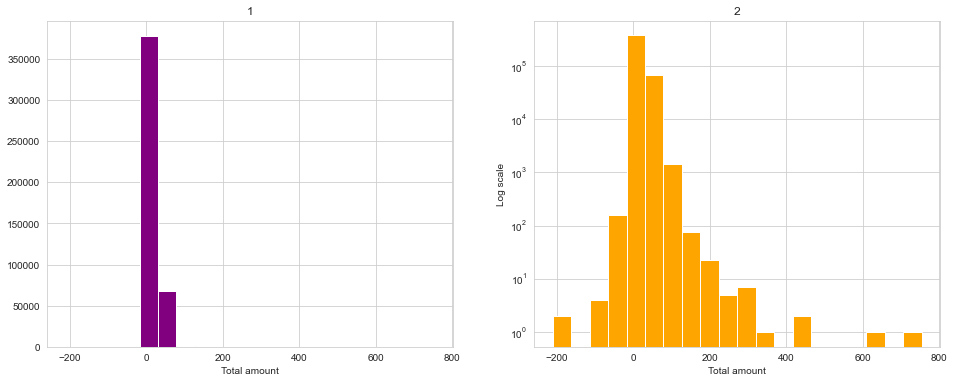

In [30]:
fig = plt.figure(figsize=(16,6))

ax = plt.subplot(1,2,1)
plt.hist(data['total_amount'], bins=20, color='purple')
plt.xlabel('Total amount')
plt.title('1')

ax = plt.subplot(122)
plt.hist(data['total_amount'], log=True, bins=20, color='orange')
plt.xlabel('Total amount')
plt.ylabel('Log scale')
plt.title('2')
plt.show()

Гистограмма 1 с абсолютными значениями не информативна, поэтому в гисторгамме 2 по оси Y приведена логарифмическая шкала.
### Видны выбросы на отметках "-200" и после "400". Также рассмотрим данные превышающие 3 стандартных отклонения.

In [31]:
std = data.total_amount.std() # стандартное отклонение по выборке
mean = data.total_amount.mean() # среднее по выборке

abnormality = data[(data.total_amount < (mean - 3*std)) | (data.total_amount > (mean + 3*std))]

In [32]:
abnormality.shape

(7475, 19)

### Итого 7475 записей. Я бы отнес их к аномалиям. Далее посмотрим на гистограмму без этих данных

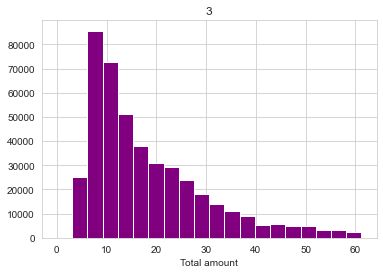

In [33]:
# Построим гистограмму без выбросов, также удерем значения чека меньше 0

drop_abnormality = data[(data.total_amount > (mean - 3*std)) & (data.total_amount < (mean + 3*std))]

# plt.hist(drop_abnormality['total_amount'], color='purple', bins=30)
plt.hist(drop_abnormality[drop_abnormality['total_amount'] > 0].total_amount, color='purple', bins=20)
plt.xlabel('Total amount')
plt.title('3')
plt.show()

Стоит заметить что в этой гистограмме значения по Y абсолютные. Т.е. можно сделать вывод что удаление аномалий позволило увидеть наглядное распределение целевой переменной в отличае от гистограмы 1

# Вывод:
- считаю данные, которые отличаются на 3 стандартных отклонения от среднего значения выбросами
- также стоит рассмотреть отрицательные суммы на включение их в выбросы, т.к. они не дают нам представления о среднем чеке

# 3. Проверка гипотезы о нормальном распределении

В целом из предыдущих гистограмм (1 и 3) видно, что распределение не является нормльным, но проверим это с помощью статистичесих методов. Параметрические статистические методы чувствительны к выбросам (аномалиям), т.к. в них считается среднее значение, поэтому будем пользоваться данными из drop_abnormality, где удалены выбросы.

***Рассмотрим визуальные представления (квантиль-квантиль график) и расчитаем p-уровень значимости по статистическим тестам***

In [35]:
from statsmodels.graphics.gofplots import qqplot

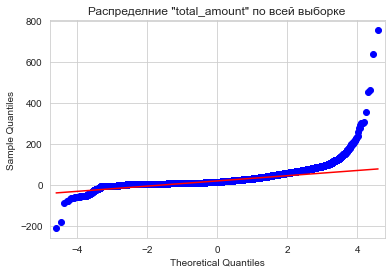

In [37]:
qqplot(data.total_amount, line='r')
plt.title('Распределние "total_amount" по всей выборке')
plt.show()

* Еще раз можно убедиться в сильных выбросах на концах выборки (min, max значения). На первый взгляд кажется, что если отбросить выбросы, то оставшиеся данные хорошо лежат на теоретической прямой нормального распределения. Дальше будем использовать данные с удаленными выбросами. Рассмотрим эти данные на аналогичном графике.

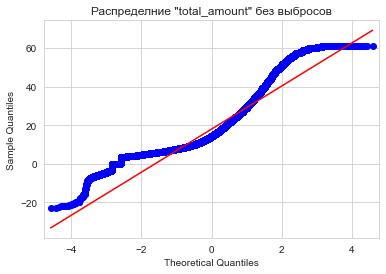

In [38]:
qqplot(drop_abnormality.total_amount, line='r')
plt.title('Распределние "total_amount" без выбросов')
plt.show()

* Даже удалив выбросы, распределение не похоже на нормлаьное. Но все равно проверим гипотезу статистическими тестами.

In [14]:
# Import Kolmogorov-Smirnov; Shapiro-Wilk; D'Agostino and Pearson's tests

from scipy.stats import kstest, shapiro, normaltest

methods = ['Kolmogorov-Smirnov', 'Shapiro-Wilk', "D'Agostino and Pearson's"]
tests = [kstest, shapiro, normaltest]

for method, test in enumerate(tests):
    if test == kstest:        
        stat, p = test(drop_abnormality.total_amount, 'norm')
    else:
        stat, p = test(drop_abnormality.total_amount)
    print('%s statistics=%.3f, p-value=%.3f' % (methods[method], stat, p))

Kolmogorov-Smirnov statistics=0.995, p-value=0.000
Shapiro-Wilk statistics=0.880, p-value=0.000
D'Agostino and Pearson's statistics=85733.018, p-value=0.000


# Вывод:
    
- Все 3 теста показали р-уровень значимости меньше 0.05. Следовательно выборка не является нормальной.
- Из гистограммы 3 видно, что наибольшее количество оплат происходит от 7 до 15-20 $, что вполне логично и показывает, что люди чаще используют такси для средних расстояний. А совсем короткие поездки или очень длинные более редкие.

# 4. Модель описывающая тариф (стоимость поездки от других факторов)

- Для описания тарифа я буду использовать хорошо интерпретируемую модель машинного обучения - Линейную регрессию

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [40]:
# Создадим данные для модели машинного обучения (Х - признаковое описание, у - зависимая переменная (цена))

X = data[(data['total_amount'] > 0) & (data['total_amount'] < mean + 3*std)] # уберем выбросы
X.drop(time_cols, axis=1, inplace=True) # уберем колонки времени, модели они не пригодятся
y = X.pop('total_amount') # целевая переменная

In [41]:
X.head()

,VendorID,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,payment_type,trip_type,congestion_surcharge
0,2.0,N,1.0,264,264,5.0,0.00,3.5,0.50,0.5,0.01,0.0,0.3,1.0,1.0,0.00
1,2.0,N,5.0,66,65,2.0,1.28,20.0,0.00,0.0,4.06,0.0,0.3,1.0,2.0,0.00
2,2.0,N,1.0,181,228,1.0,2.47,10.5,0.50,0.5,3.54,0.0,0.3,1.0,1.0,0.00
3,1.0,N,1.0,129,263,2.0,6.30,21.0,3.25,0.5,0.00,0.0,0.3,2.0,1.0,2.75
4,1.0,N,1.0,210,150,1.0,2.30,10.0,0.50,0.5,0.00,0.0,0.3,1.0,1.0,0.00


In [44]:
for col in data.columns:
    print(f'Колонка "{col}" имеет значений: {data[col].nunique()}')

Колонка "VendorID" имеет значений: 2
Колонка "lpep_pickup_datetime" имеет значений: 331157
Колонка "lpep_dropoff_datetime" имеет значений: 331043
Колонка "store_and_fwd_flag" имеет значений: 2
Колонка "RatecodeID" имеет значений: 7
Колонка "PULocationID" имеет значений: 251
Колонка "DOLocationID" имеет значений: 257
Колонка "passenger_count" имеет значений: 10
Колонка "trip_distance" имеет значений: 3555
Колонка "fare_amount" имеет значений: 6037
Колонка "extra" имеет значений: 13
Колонка "mta_tax" имеет значений: 4
Колонка "tip_amount" имеет значений: 1468
Колонка "tolls_amount" имеет значений: 94
Колонка "improvement_surcharge" имеет значений: 3
Колонка "total_amount" имеет значений: 7072
Колонка "payment_type" имеет значений: 5
Колонка "trip_type" имеет значений: 2
Колонка "congestion_surcharge" имеет значений: 5


В исходных данных было много пропущенных значений, еще раз посмотрим на них

In [42]:
X.isnull().sum()

VendorID                 111709
store_and_fwd_flag       111709
RatecodeID               111709
PULocationID                  0
DOLocationID                  0
passenger_count          111709
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
payment_type             111709
trip_type                111710
congestion_surcharge     111709
dtype: int64

Заменим пропущенные значения медианными (если брать среднее могут появиться не целые числа в категориальных столбцах. Нам этого не надо)

In [43]:
for col in X.columns:
    if X[col].isnull().any():
        if X[col].dtype == 'object':
            pass
        else:
            X[col].fillna(X[col].median(), inplace=True)

In [44]:
X.isnull().sum()

VendorID                      0
store_and_fwd_flag       111709
RatecodeID                    0
PULocationID                  0
DOLocationID                  0
passenger_count               0
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
payment_type                  0
trip_type                     0
congestion_surcharge          0
dtype: int64

In [45]:
X.drop('store_and_fwd_flag', inplace=True, axis=1) # уберем колонку store_and_fwd_flag. 
                                                   # Она описывает состояние записи до заказа такси и не информативна для модели

In [46]:
# Применим нормировку к данным, т.к. Linear Regression чувствительна к масштабу данных

scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
scaled_X.head()

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,payment_type,trip_type,congestion_surcharge
0,0.379844,-0.119437,2.200876,1.770072,4.519505,-0.919148,-1.081318,-0.290954,0.517565,-0.539475,-0.206183,0.192595,-0.695585,-0.123379,-0.385058
1,0.379844,7.274487,-0.588104,-0.834634,0.926130,-0.567294,0.453088,-0.730222,-1.927454,1.997921,-0.206183,0.192595,-0.695585,8.105096,-0.385058
2,0.379844,-0.119437,1.031758,1.298869,-0.271661,-0.240179,-0.430358,-0.290954,0.517565,1.672132,-0.206183,0.192595,-0.695585,-0.123379,-0.385058
3,-2.632658,-0.119437,0.299299,1.756983,0.926130,0.812633,0.546082,2.125021,0.517565,-0.545740,-0.206183,0.192595,1.386039,-0.123379,2.597412
4,-2.632658,-0.119437,1.440245,0.277929,-0.271661,-0.286910,-0.476855,-0.290954,0.517565,-0.545740,-0.206183,0.192595,-0.695585,-0.123379,-0.385058


In [47]:
model = LinearRegression()
model.fit(scaled_X, y)

# посмотрим на точность модели
model.score(scaled_X, y)

0.9990859294021606

Такая высокая точноть объясняется тем, что модель переобучилась (выучила все закономерности) данного датасета. Посмотрим на коэффициенты модели.

In [48]:
names = ['Intercept']
for n in scaled_X.columns:
    names.append(n)

coefs = [model.intercept_]
for n in model.coef_:
    coefs.append(n)

coef_df = pd.DataFrame(data=coefs, index=names, columns=['Scores'])

In [49]:
coef_df

,Scores
Intercept,18.093250
VendorID,0.144131
RatecodeID,0.002844
PULocationID,0.003924
DOLocationID,-0.001311
passenger_count,-0.002741
trip_distance,-0.061752
fare_amount,10.840516
extra,0.967158
mta_tax,0.173897


Из таблицы мы видим, что некоторые коэффициенты близки к нулю. Это значит, что соответствующая колонка не вносит вклада в прогнозирование. Т.е. какое бы большое число не значилось в колонке датасета (например RatecodeID или passenger_count) модель их занулит. Поэтому эти признаки можно убрать из модели. Оставим только те признаки, коэффициент при которых около 1 или больше и переобучим модель.

In [50]:
usefull_cols_X = scaled_X[['fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'congestion_surcharge']]
usefull_cols_X.head()

,fare_amount,extra,tip_amount,tolls_amount,congestion_surcharge
0,-1.081318,-0.290954,-0.539475,-0.206183,-0.385058
1,0.453088,-0.730222,1.997921,-0.206183,-0.385058
2,-0.430358,-0.290954,1.672132,-0.206183,-0.385058
3,0.546082,2.125021,-0.545740,-0.206183,2.597412
4,-0.476855,-0.290954,-0.545740,-0.206183,-0.385058


В таблице остались различные сборы, чаевые и расчетные параметры. Они будут влиять на конечную цену поездки. И это логично, так как количество пассажиров или метод оплаты не должен сильно влиять на конечную цену.

In [51]:
model_2 = LinearRegression()
model_2.fit(usefull_cols_X, y)

model_2.score(usefull_cols_X, y)

0.9988483856256825

Score стал незначительно меньше, что подтверждает вывод о незначительном вкладе исключенных колонок

In [52]:
names_2 = ['Intercept']
for name in usefull_cols_X.columns:
    names_2.append(name)

coefs_2 = [round(model_2.intercept_,2)]
for coef in model_2.coef_:
    coefs_2.append(round(coef,2))

coef_df_2 = pd.DataFrame(data=coefs_2, index=names_2, columns=['Scores'])

In [53]:
coef_df_2

,Scores
Intercept,18.09
fare_amount,10.74
extra,0.92
tip_amount,1.64
tolls_amount,1.25
congestion_surcharge,0.81


## Выводы:
    
- Основные факторы влияющие на цену поездки приведены в таблице выше.
- Как было уже описано, в таблице присутствуют различные надбавки, сборы, чаевые, рассчетные значения цены за пройденный метр и отсутствуют факторы количества пассажиров, способа оплаты и т.д. Что вполне разумно, так как последние вносят незначительный вклад в ценообразование.
- Стоит заметить что в таблице присутствует значение Intercept. Это так называемый свободный член. Он показывает какое значение выдаст модель, если ничего не известно про объект прогнозирования (по сути, это среднее значение по выборке).
- В таблице коэффициентов отсутствуют отрицательные значения и кажется, что сумма чека может только увеличиваться, но я делал нормировку даных (вычитание среднего значения и деление на дисперсию). И таким образом после процедуры StandardScaler в данных появились отрицательные значения, хотя в изначальном датасете их не было.

# 5. Скидки и акции

Рассмотрим сумму чеков и среднее значение по дням. Затем сделаем визуализацию полученных данных

In [54]:
import datetime

Проверим временные данные

In [57]:
date_df = data[['lpep_dropoff_datetime', 'total_amount']]
date_df.sort_values('lpep_dropoff_datetime').head()

,lpep_dropoff_datetime,total_amount
293876,2008-12-31 23:12:08,0.00
129035,2009-01-01 00:17:31,9.80
129036,2009-01-01 00:45:10,11.55
87957,2009-01-01 00:58:27,11.80
129037,2009-01-01 01:00:23,10.05


In [58]:
data['lpep_dropoff_datetime'].min(), data['lpep_dropoff_datetime'].max()

(Timestamp('2008-12-31 23:12:08'), Timestamp('2020-02-02 00:09:54'))

Мы видим, что данные по времени не совсем "чистые". В описании к датасету было сказано, что данные предоставлены за январь 2020 года. Уберем лишние данные по времени и аномалии по стоимости поездки

In [59]:
date_df.shape

(447770, 2)

In [60]:
start_day = datetime.datetime(2020, 1, 1)
end_day = datetime.datetime(2020, 1, 31)

date_df = date_df[(date_df['lpep_dropoff_datetime'].gt(start_day) & (date_df['lpep_dropoff_datetime'].lt(end_day)) &
                   (date_df['total_amount'] > 0) & (date_df['total_amount'] < mean + 3*std))]

In [61]:
date_df.sort_values('lpep_dropoff_datetime').head()

,lpep_dropoff_datetime,total_amount
398,2020-01-01 00:01:09,7.30
181,2020-01-01 00:04:49,8.76
665,2020-01-01 00:05:04,30.30
320,2020-01-01 00:05:50,4.80
730,2020-01-01 00:06:20,4.80


Начальная дата теперь правильная (1 января 2020г). Посмотрим на размер данных

In [62]:
date_df.shape

(422736, 2)

Примерно 25000 записей ушло из выборки

In [63]:
# Выделим из даты только день. Т.к. в дальнейшем будем по нему группировать

date_df['day'] = date_df.lpep_dropoff_datetime.apply(lambda x: x.day)

date_df.drop('lpep_dropoff_datetime', axis=1, inplace=True)

In [67]:
date_df.head()

,total_amount,day
1,24.36,1
2,15.34,1
3,25.05,1
4,11.30,1
5,14.80,1


Посмотрим на графики суммы и среднего значения по цене с группировкой по дню месяца

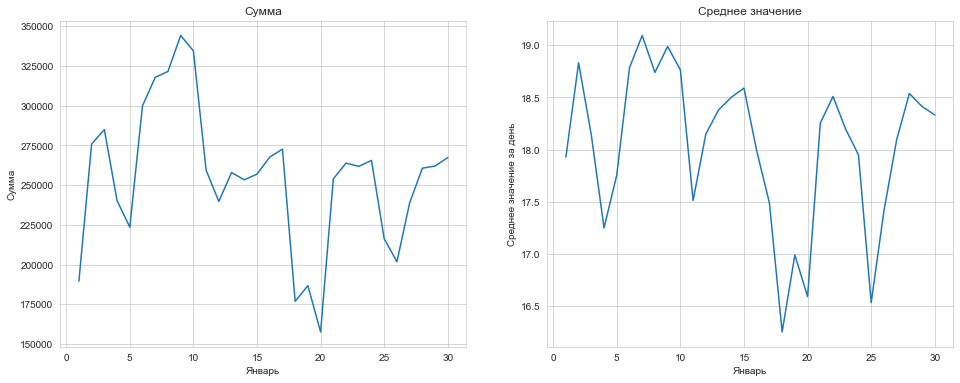

In [69]:
fig = plt.figure(figsize=(16,6))

ax = plt.subplot(1,2,1)

sns.lineplot(data=date_df.groupby('day').sum(), x='day', y='total_amount')
plt.xlabel('Январь')
plt.ylabel('Сумма')
plt.title('Сумма')

ax = plt.subplot(122)
sns.lineplot(data=date_df.groupby('day').mean(), x='day', y='total_amount')
plt.xlabel('Январь')
plt.ylabel('Среднее значение за день')
plt.title('Среднее значение')
plt.show()

# Выводы:

- Графики суммы и среднего отличаются и оба информативные. Потому что только по сумме нельзя определить была ли акция или нет. Важно смотреть еще на среднее, т.е. на количество заказов. Например 1 января общая сумма одна из самых низких, но разделив сумму на кол-во заказов видим, что это абсолютно средний день по чеку.
- На 2м графике мы видим явные просадки по средней сумме в день. Я бы отметил 18 - 20, 25 января как дни акций и скидок, так как средний чек в эти дни уменьшился.
- Стоит отметить, что 18 - 20, 25 января не являются праздниками, но могут быть выходными днями (не все, но например 18 и 25 или только 20) что может влиять на спрос такси.